In [6]:
import kagglehub
import re
import spacy
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
from torch_geometric.data import Data
from transformers import AutoTokenizer, AutoModel
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

# Download Dataset
dataset_dir = kagglehub.dataset_download("crowdflower/political-social-media-posts")

print("Path to dataset directory:", dataset_dir)

# Find the CSV file within the directory
for filename in os.listdir(dataset_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(dataset_dir, filename)
        break  # Stop searching after finding the first CSV file

print("Path to dataset files:", file_path)

# Read the CSV file, specifying the encoding
data = pd.read_csv(file_path, encoding='latin-1')  # Changed line: Added encoding parameter

# Display the first few rows
print(data.head())
# ... (rest of the code remains the same)

# Step 4: Clean the text
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters and digits
    text = text.lower()  # Convert to lowercase
    text = " ".join(text.split())  # Remove extra whitespace
    return text

data["text"] = data["text"].apply(clean_text)
print(data["text"].head())  # Check cleaned text

# Step 5: Extract entities
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

data["entities"] = data["text"].apply(extract_entities)
print(data["entities"].head())  # Check extracted entities

# Step 6: Encode bias labels
label_encoder = LabelEncoder()
data["bias_label_encoded"] = label_encoder.fit_transform(data["bias"])
print(data[["bias", "bias_label_encoded"]].head())

# Step 7: Load pre-trained BERT model and tokenizer
model_name = 'distilbert-base-uncased'  # Smaller and faster model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Step 8: Generate BERT embeddings for articles and entities
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token
    return embeddings.numpy().reshape(-1)  # Reshape to (768,)

# Generate embeddings for articles
article_embeddings = [get_bert_embedding(text) for text in data["text"]]

# Cache entity embeddings to avoid recomputation
entity_embeddings = {}
for entities in data["entities"]:
    for entity in entities:
        if entity not in entity_embeddings:
            entity_embeddings[entity] = get_bert_embedding(entity)

# Step 9: Build the graph
node_features = []  # List of node features (e.g., embeddings)
edge_index = []     # List of edges (e.g., co-occurrence)
labels = []         # List of bias labels

# Add article nodes
node_features.extend(article_embeddings)
labels.extend(data["bias_label_encoded"].tolist())

# Add entity nodes and edges
for idx, row in data.iterrows():
    for entity in row["entities"]:
        node_features.append(entity_embeddings[entity])
        edge_index.append([idx, len(node_features) - 1])  # Connect article to entity

# Convert to PyTorch tensors
node_features = torch.tensor(np.array(node_features), dtype=torch.float)  # Convert list of arrays to tensor
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
labels = torch.tensor(labels, dtype=torch.long)

# Create PyTorch Geometric data object
graph_data = Data(x=node_features, edge_index=edge_index, y=labels)
print(graph_data)

# Step 10: Split the data into training, validation, and test sets
from torch_geometric.data import DataLoader

# Create masks with the correct size for the graph data
train_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)

# Apply masks only to the article nodes (first len(data) nodes)
num_articles = len(data)
train_mask[:int(0.7 * num_articles)] = True
val_mask[int(0.7 * num_articles):int(0.85 * num_articles)] = True
test_mask[int(0.85 * num_articles):num_articles] = True

graph_data.train_mask = train_mask
graph_data.val_mask = val_mask
graph_data.test_mask = test_mask

# Step 11: Define the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model
model = GNN(input_dim=node_features.shape[1], hidden_dim=64, output_dim=2)  # 2 classes for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Step 12: Train the model
def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    # Apply the mask only to the article nodes' output and labels
    loss = F.cross_entropy(out[graph_data.train_mask][:num_articles],
                          graph_data.y[:num_articles][graph_data.train_mask[:num_articles]])
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(100):
    loss = train()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Step 13: Test the model
def test():
    model.eval()
    out = model(graph_data.x, graph_data.edge_index)
    pred = out.argmax(dim=1)

    # Ensure the test mask only applies to article nodes
    article_test_mask = graph_data.test_mask[:num_articles]  # Slice the mask to match article nodes

    # Slice predictions and labels to match article nodes
    pred_articles = pred[:num_articles][article_test_mask]  # Predictions for article nodes
    true_labels = graph_data.y[:num_articles][article_test_mask]  # True labels for article nodes

    # Calculate accuracy
    correct = pred_articles == true_labels
    accuracy = int(correct.sum()) / int(article_test_mask.sum())
    return accuracy

# Test the model
accuracy = test()
print(f"Test Accuracy: {accuracy:.4f}")

# Step 14: Save the model
torch.save(model.state_dict(), "gnn_model.pth")

Path to dataset directory: /root/.cache/kagglehub/datasets/crowdflower/political-social-media-posts/versions/1
Path to dataset files: /root/.cache/kagglehub/datasets/crowdflower/political-social-media-posts/versions/1/political_social_media.csv
    _unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
0  766192484    False   finalized                   1      8/4/15 21:17   
1  766192485    False   finalized                   1      8/4/15 21:20   
2  766192486    False   finalized                   1      8/4/15 21:14   
3  766192487    False   finalized                   1      8/4/15 21:08   
4  766192488    False   finalized                   1      8/4/15 21:26   

   audience  audience:confidence      bias  bias:confidence  message  ...  \
0  national                  1.0  partisan              1.0   policy  ...   
1  national                  1.0  partisan              1.0   attack  ...   
2  national                  1.0   neutral              1.0  support  ...

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Data(x=[14133, 768], edge_index=[2, 9133], y=[5000])
Epoch 1, Loss: 0.5788483619689941
Epoch 2, Loss: 2.3852946758270264
Epoch 3, Loss: 1.2888962030410767
Epoch 4, Loss: 1.6361515522003174
Epoch 5, Loss: 1.3816345930099487
Epoch 6, Loss: 0.9603712558746338
Epoch 7, Loss: 0.5865874290466309
Epoch 8, Loss: 0.5213299989700317
Epoch 9, Loss: 0.6904460787773132
Epoch 10, Loss: 0.7644170522689819
Epoch 11, Loss: 0.6883044838905334
Epoch 12, Loss: 0.5766739249229431
Epoch 13, Loss: 0.511183500289917
Epoch 14, Loss: 0.49994567036628723
Epoch 15, Loss: 0.5158679485321045
Epoch 16, Loss: 0.5350838899612427
Epoch 17, Loss: 0.5468063950538635
Epoch 18, Loss: 0.5481902360916138
Epoch 19, Loss: 0.5405331254005432
Epoch 20, Loss: 0.5274096727371216
Epoch 21, Loss: 0.5131726861000061
Epoch 22, Loss: 0.5015676021575928
Epoch 23, Loss: 0.49495622515678406
Epoch 24, Loss: 0.49379962682724
Epoch 25, Loss: 0.4956851303577423
Epoch 26, Loss: 0.4975825250148773
Epoch 27, Loss: 0.49758848547935486
Epoch 28, L

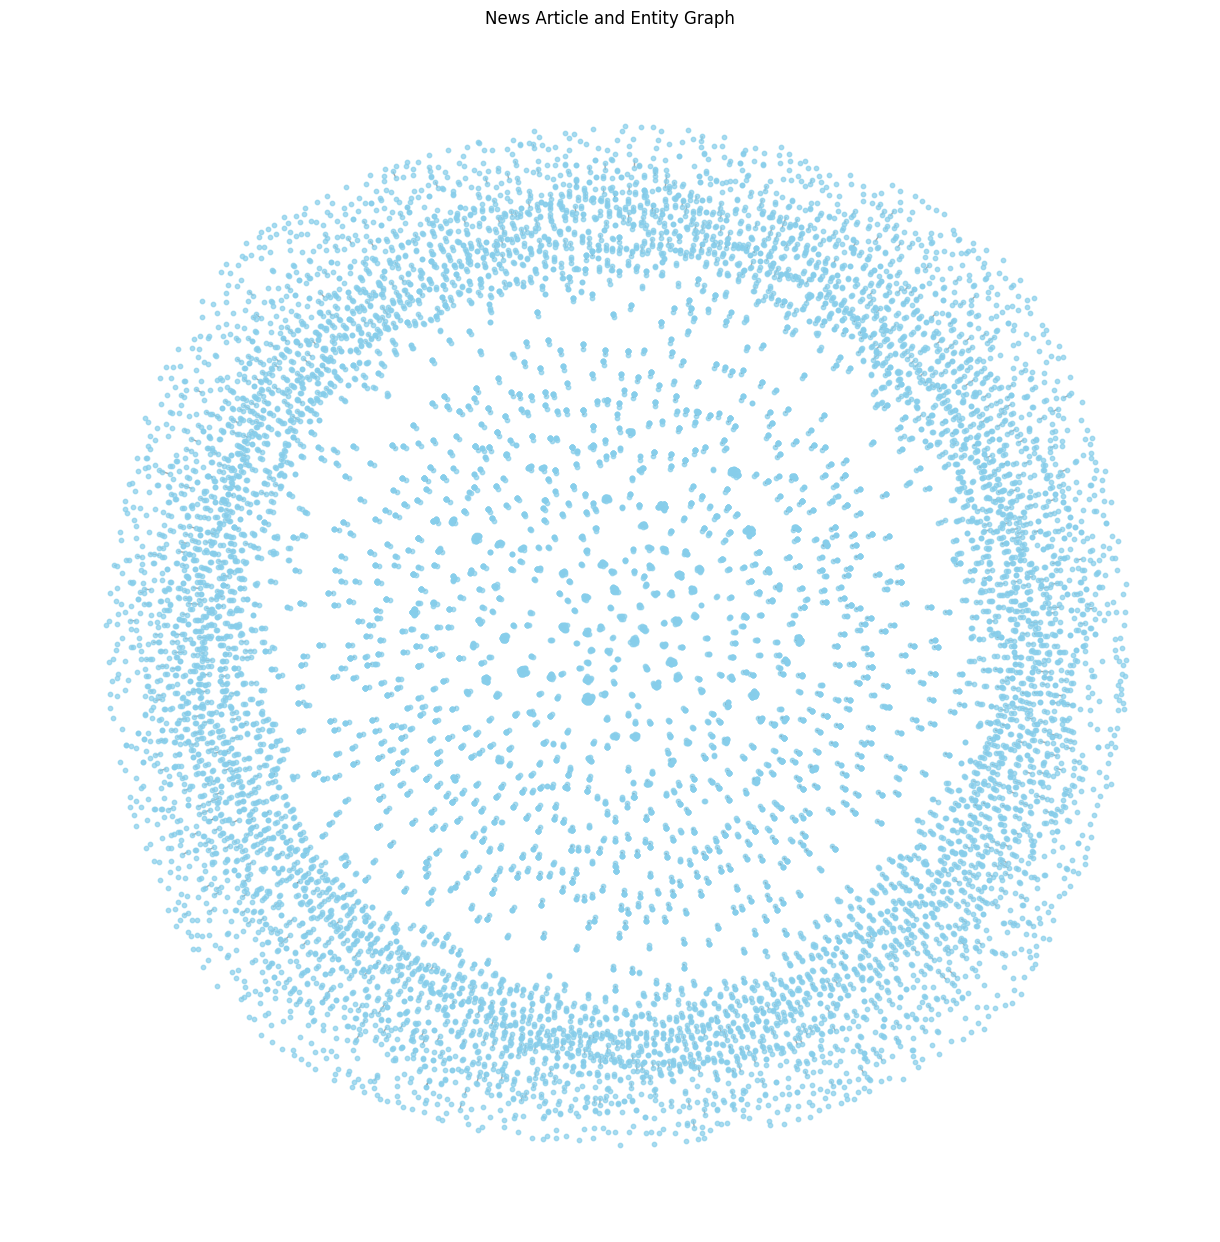

In [7]:
# prompt: Visualize the Graph:


# Assuming 'graph_data' is your PyTorch Geometric Data object
# Extract the necessary information
edge_index = graph_data.edge_index.numpy()
num_nodes = graph_data.num_nodes

# Create a NetworkX graph
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edge_index.T)

# Visualize the graph
plt.figure(figsize=(12, 12))  # Adjust figure size for better visualization
pos = nx.spring_layout(G, seed=42)  # Use a layout algorithm (e.g., spring_layout)
nx.draw(G, pos, with_labels=False, node_size=10, node_color="skyblue", edge_color="gray", alpha=0.7)
plt.title("News Article and Entity Graph")
plt.show()


In [8]:
# Print graph data
print("Number of Nodes:", node_features.shape[0])
print("Number of Edges:", edge_index.shape[1])
print("Number of Labels:", labels.shape[0])

Number of Nodes: 14133
Number of Edges: 9133
Number of Labels: 5000


In [9]:
# Print mask sizes
print("Train Mask Size:", train_mask.shape[0])
print("Val Mask Size:", val_mask.shape[0])
print("Test Mask Size:", test_mask.shape[0])

Train Mask Size: 14133
Val Mask Size: 14133
Test Mask Size: 14133
